# Fashion Style Classifier: End-to-End Machine Learning Project
 
## Project Overview
This project tackles the problem of fashion style classification using a real-world, non-standard image dataset. The goal is to build, compare, and evaluate multiple machine learning models for classifying fashion images into different style categories.

**Key Steps:**
- Data curation, cleaning, and preprocessing (including manual annotation if applicable)
- Exploratory data analysis and class balance visualization
- Robust error handling for missing or corrupt files
- Model training and evaluation:
    - Deep learning (CNN with MobileNetV2, transfer learning, fine-tuning, advanced augmentation, class weights)
    - Classical machine learning (KNN on deep features)
    - Naive baseline (most frequent class)
- Model comparison using multiple metrics (accuracy, precision, recall, f1-score)
- K-fold cross-validation for KNN
- Reproducible code and clear workflow
- GitHub workflow with branch-based collaboration

## How to Use This Notebook
1. **Install dependencies**: Ensure all packages in `requirements.txt` are installed in your environment.
2. **Prepare the data**: Place the labeled CSV and image files in the expected directories as described in the code comments.
3. **Run all cells**: The notebook is designed to run top-to-bottom, handling missing files and errors gracefully.
4. **Review outputs**: Key metrics, confusion matrices, and sample predictions are displayed for each model.
5. **Compare models**: Results for CNN, KNN, and the naive baseline are reported and compared.

## Experimental Setup & Key Findings
- **Dataset**: Real-world fashion images, manually cleaned and preprocessed.
- **Models**:
    - CNN (MobileNetV2): Transfer learning, fine-tuning, advanced augmentation, class weights.
    - KNN: Trained on features extracted from MobileNetV2.
    - Naive baseline: Always predicts the most frequent class.
- **Evaluation**: Models are compared using accuracy, precision, recall, and f1-score. KNN is further evaluated with k-fold cross-validation.
- **Findings**: (Fill in your key results and insights after running the notebook)

## Challenges & Literature
- Handling class imbalance and missing/corrupt images.
- Achieving good generalization with limited or imbalanced data.
- (Add references to relevant ML literature or similar works if desired)

## Repo Navigation & Reproducibility
- All code is in this notebook; dependencies are in `requirements.txt`.
- Data paths and preprocessing steps are clearly documented in code comments.
- To rerun experiments, follow the notebook top-to-bottom after setting up your environment and data.
- For team collaboration, use GitHub branches and merge to main/master for final submission.

## Team & Contributions
- (List all team members and their contributions here)

## Final Notes
- For best results, tune hyperparameters and review error cases.
- For extra points, consider running on a remote cluster or adding more advanced baselines.
- Tag your final commit with `v1.0` for grading.

In [31]:
# Import TensorFlow and check version
import tensorflow as tf
print(tf.__version__)  # Print TensorFlow version to ensure correct environment

2.19.0


## Environment Setup: Import TensorFlow and Check Version
This cell imports TensorFlow, the main deep learning library used in this project, and prints its version. Ensuring the correct TensorFlow version is important for compatibility with Keras and other dependencies.

In [32]:
# Install TensorFlow if not already installed (uncomment if needed)
# %pip install tensorflow

# Import required libraries for data handling, visualization, and modeling
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import os  # File and directory operations
import matplotlib.pyplot as plt  # Plotting and visualization
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.preprocessing import LabelEncoder  # Label encoding for categorical variables
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Image loading and conversion
from tensorflow.keras.utils import to_categorical  # One-hot encoding for labels
from tensorflow.keras.applications import MobileNetV2  # Pre-trained CNN model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Model layers
from tensorflow.keras.models import Model  # Model construction
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation

## Import Required Libraries
This cell imports all the necessary Python libraries for data manipulation (pandas, numpy), file operations (os), visualization (matplotlib, seaborn), and machine learning (scikit-learn, TensorFlow/Keras). These libraries are essential for building, training, and evaluating the models in this project.

In [33]:
# Load the labeled CSV file containing image paths and style labels
csv_path = './Dataset/project-2-at-2025-07-13-20-49-69d4a9dd.csv'  # Path to your dataset CSV
df = pd.read_csv(csv_path)  # Read the CSV into a DataFrame

# Preview the first few rows to understand the data structure
df.head()

annotation_id  annotator      choice                   created_at  id  \
0              1          1  streetwear  2025-07-13T14:06:47.817786Z   1   
1              2          1  streetwear  2025-07-13T14:06:52.413641Z   2   
2              3          1      casual  2025-07-13T14:07:02.105802Z   3   
3              4          1      casual  2025-07-13T14:07:06.161496Z   4   
4              5          1     vintage  2025-07-13T14:07:10.580991Z   5   

                                        image  lead_time  \
0  /data/upload/2/8c0dddfa-streetwear_706.jpg      6.106   
1  /data/upload/2/9c61426e-streetwear_705.jpg     17.992   
2  /data/upload/2/e4442caf-streetwear_701.jpg      2.541   
3  /data/upload/2/0096a173-streetwear_699.jpg      3.060   
4  /data/upload/2/109daa13-streetwear_698.jpg     13.651   

                    updated_at  
0  2025-07-13T14:24:14.261162Z  
1  2025-07-13T14:24:19.881258Z  
2  2025-07-13T14:07:02.105841Z  
3  2025-07-13T14:07:06.161533Z  
4  2025-07-13T14:24:39.311053Z

## Load Labeled Data
This cell loads the labeled CSV file containing image paths and style labels into a pandas DataFrame. Previewing the first few rows helps verify the data structure and ensures the file is loaded correctly.

In [34]:
# Use all available images for training and evaluation (no sampling or limit)
df_full = df.copy()  # Work on a copy to preserve the original data

# Fix image paths to point to the correct Dataset/images/ directory
def fix_image_path(path):
    # Convert Label Studio or other tool paths to local image directory paths
    if path.startswith('/data/upload/2/'):
        return './Dataset/images/' + path.split('/')[-1]
    return path

df_full['image'] = df_full['image'].apply(fix_image_path)  # Apply path fixing

# Check if images exist and display the sample
def check_image_exists(row):
    return os.path.exists(row['image'])

df_full['exists'] = df_full.apply(check_image_exists, axis=1)  # Mark missing files

# Remove rows with missing image files for robust training
df_full = df_full[df_full['exists']].reset_index(drop=True)
print(df_full[['image', 'choice', 'exists']])  # Show cleaned data
print(f"Sample size after removing missing files: {len(df_full)}")

                                            image      choice  exists
0    ./Dataset/images/8c0dddfa-streetwear_706.jpg  streetwear    True
1    ./Dataset/images/9c61426e-streetwear_705.jpg  streetwear    True
2    ./Dataset/images/e4442caf-streetwear_701.jpg      casual    True
3    ./Dataset/images/0096a173-streetwear_699.jpg      casual    True
4    ./Dataset/images/109daa13-streetwear_698.jpg     vintage    True
..                                            ...         ...     ...
578       ./Dataset/images/72e679fe-fashion_8.jpg      formal    True
579       ./Dataset/images/02e61e02-fashion_7.jpg      casual    True
580       ./Dataset/images/8e2e1222-fashion_5.jpg      formal    True
581       ./Dataset/images/30838853-fashion_4.jpg      formal    True
582       ./Dataset/images/f9110e7c-fashion_3.jpg      sporty    True

[583 rows x 3 columns]
Sample size after removing missing files: 583


## Data Cleaning: Use All Images, Fix Paths, and Filter Missing Files
This cell ensures that all available images are used for training and evaluation. It fixes image paths to match the local directory structure, checks for missing files, and removes any rows with missing images to ensure robust training.

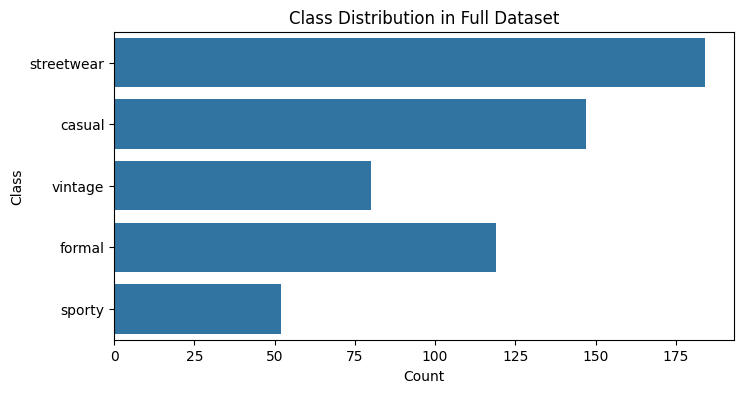

choice
streetwear    184
casual        147
formal        119
vintage        80
sporty         52
Name: count, dtype: int64


In [35]:
# Print class distribution and visualize class balance to check for imbalance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(y=df_full['choice'])  # Visualize class counts
plt.title('Class Distribution in Full Dataset')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()
print(df_full['choice'].value_counts())  # Print class counts

## Visualize Class Distribution
This cell visualizes the distribution of style classes in the dataset using a countplot. Understanding class balance is important for model training and evaluation, especially if the dataset is imbalanced.

In [36]:
# Remove rows with missing image files from the full dataset (redundant if already done above, but ensures robustness)
def file_exists(row):
    return os.path.exists(row['image'])  # image path is already fixed above

df_full = df_full[df_full.apply(file_exists, axis=1)].reset_index(drop=True)
print(f"Sample size after removing missing files: {len(df_full)}")

Sample size after removing missing files: 583


## Additional Missing File Filtering (Redundancy for Robustness)
This cell performs an extra check to remove any rows with missing image files. While this may be redundant if already done, it ensures that only valid images are used for training and evaluation, making the workflow more robust.

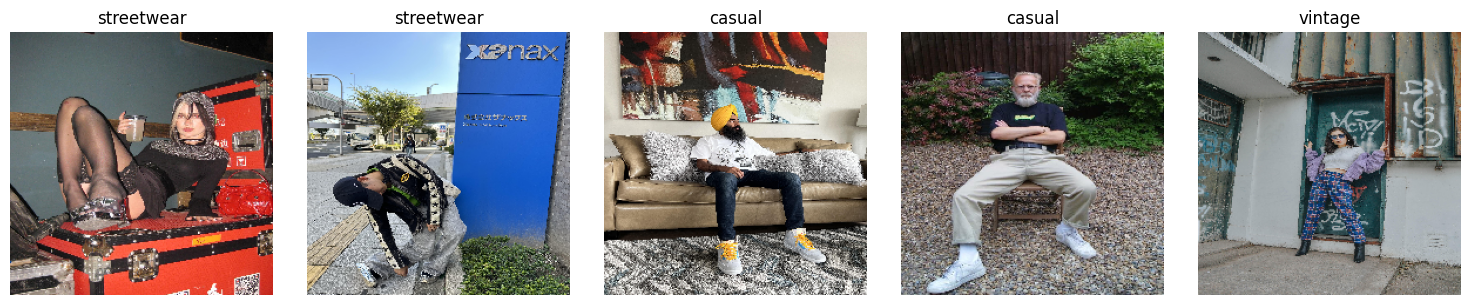

In [37]:
# Load, preprocess, and visualize a few sample images from the full dataset
img_size = (224, 224)  # Standard input size for MobileNetV2

if df_full.empty:
    print("No images to display after filtering missing files.")
else:
    fig, axes = plt.subplots(1, min(5, len(df_full)), figsize=(15, 3))
    for i, (idx, row) in enumerate(df_full.head(5).iterrows()):
        img_path = row['image']  # path is already fixed
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=img_size)  # Load and resize image
            img_arr = img_to_array(img) / 255.0  # Normalize to [0,1]
            axes[i].imshow(img_arr)
            axes[i].set_title(row['choice'])
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## Visualize Sample Images
This cell loads, preprocesses, and displays a few sample images from the cleaned dataset. Visual inspection helps verify that image paths are correct and that preprocessing (resizing, normalization) is working as intended.

In [38]:
# Encode labels and split the full data into train and test sets
from sklearn.preprocessing import LabelEncoder

# Remove classes with fewer than 2 samples to avoid stratified split errors
class_counts = df_full['choice'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_full_filtered = df_full[df_full['choice'].isin(valid_classes)].reset_index(drop=True)

if df_full_filtered.empty:
    print("No valid classes with at least 2 samples. Please check your dataset.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    le = LabelEncoder()
else:
    le = LabelEncoder()
    df_full_filtered['label'] = le.fit_transform(df_full_filtered['choice'])  # Encode class labels as integers
    # Stratified split to maintain class proportions
    train_df, test_df = train_test_split(df_full_filtered, test_size=0.3, stratify=df_full_filtered['label'], random_state=42)
    print('Train size:', len(train_df), 'Test size:', len(test_df))
    print('Classes:', le.classes_)

Train size: 407 Test size: 175
Classes: ['casual' 'formal' 'sporty' 'streetwear' 'vintage']


## Encode Labels and Stratified Train-Test Split
This cell encodes the categorical style labels as integers and splits the data into training and test sets using stratified sampling. Stratification ensures that class proportions are maintained in both sets, which is important for fair model evaluation.

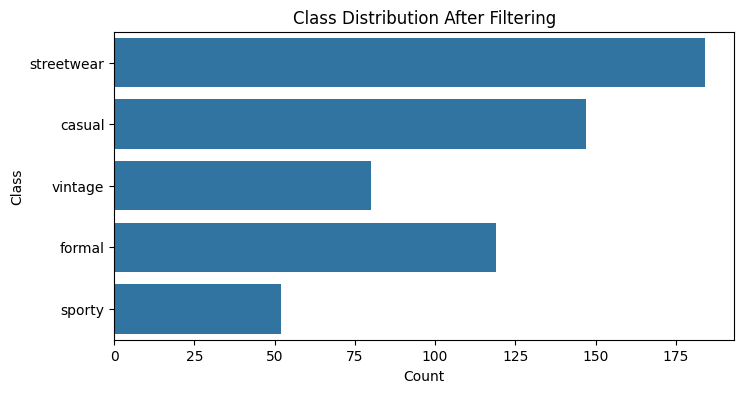

choice
streetwear    184
casual        147
formal        119
vintage        80
sporty         52
Name: count, dtype: int64
Class weights: {0: 0.7918367346938775, 1: 0.9781512605042016, 2: 2.2384615384615385, 3: 0.6326086956521739, 4: 1.455}


In [39]:
# Visualize class distribution after filtering and compute class weights for imbalanced classes
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

if not df_full_filtered.empty:
    plt.figure(figsize=(8,4))
    sns.countplot(y=df_full_filtered['choice'])  # Visualize class counts after filtering
    plt.title('Class Distribution After Filtering')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()
    print(df_full_filtered['choice'].value_counts())

    # Compute class weights for imbalanced classes (helps CNN training)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_full_filtered['label']), y=df_full_filtered['label'])
    class_weights_dict = {i : w for i, w in enumerate(class_weights)}
    print('Class weights:', class_weights_dict)
else:
    class_weights_dict = None

## Visualize Class Distribution After Filtering and Compute Class Weights
This cell visualizes the class distribution after filtering out rare classes and computes class weights to address class imbalance. Class weights help the CNN model pay more attention to underrepresented classes during training.

In [40]:
# Create data generators for training and testing with advanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    rotation_range=40,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    zoom_range=0.3,  # Randomly zoom images
    brightness_range=[0.6,1.4],  # Randomly change brightness
    shear_range=0.2,  # Shear transformation
    channel_shift_range=30.0,  # Randomly shift color channels
    fill_mode='nearest',  # Fill in missing pixels after transformation
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input  # Preprocess for MobileNetV2
    )
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

def dataframe_to_generator(df, datagen, batch_size=4):
    # Converts a DataFrame of image paths and labels into a Keras data generator
    if df.empty or 'image' not in df.columns or 'label' not in df.columns:
        return None
    paths = df['image'].values
    labels = df['label'].values
    imgs = []
    valid_labels = []
    for p, label in zip(paths, labels):
        try:
            img = img_to_array(load_img(p, target_size=img_size))
            imgs.append(img)
            valid_labels.append(label)
        except Exception as e:
            print(f"Warning: Could not load image {p}: {e}")
    if not imgs:
        return None
    imgs = np.array(imgs)
    return datagen.flow(imgs, to_categorical(valid_labels, num_classes=len(le.classes_)), batch_size=batch_size)

train_gen = dataframe_to_generator(train_df, train_datagen) if not train_df.empty else None
test_gen = dataframe_to_generator(test_df, test_datagen) if not test_df.empty else None

## Create Data Generators with Augmentation
This cell creates Keras data generators for training and testing. The training generator applies advanced data augmentation to improve model generalization, while the test generator only rescales and preprocesses images.

In [41]:
# Build a transfer learning model using MobileNetV2 with fine-tuning and callbacks for better accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

if train_gen is None or test_gen is None or train_df.empty or test_df.empty:
    print("No data available for training or testing. Please check your dataset and preprocessing steps.")
    model = None
else:
    # Clear any previous session to avoid clutter from old models/layers
    tf.keras.backend.clear_session()

    # Use MobileNetV2 as the base model (pre-trained on ImageNet)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers for initial training

    # Add custom classification head for our dataset
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(len(le.classes_), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks for early stopping, best model saving, and learning rate reduction
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    # Train initial model with class weights if available
    steps_per_epoch = max(1, len(train_df) // 4)
    validation_steps = max(1, len(test_df) // 4)
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=30,
        validation_data=test_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict if class_weights_dict is not None else None
    )

    # Unfreeze more layers for fine-tuning (e.g., last 50 layers)
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Re-compile with lower learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tune the model for additional epochs
    history_finetune = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=15,
        validation_data=test_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict if class_weights_dict is not None else None
    )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30


b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1920 - loss: 1.7504

101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.1920 - loss: 1.7504 - val_accuracy: 0.1395 - val_loss: 1.6957 - learning_rate: 5.0000e-04
Epoch 2/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0000e+00 - loss: 1.3634

b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 1.3634 - val_accuracy: 0.1395 - val_loss: 1.7085 - learning_rate: 5.0000e-04
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2300 - loss: 1.6070 - val_accuracy: 0.0930 - val_loss: 1.8889 - learning_rate: 5.0000e-04
Epoch 4/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5000 - loss: 1.5479
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5000 - loss: 1.5479 - val_accuracy: 0.0930 - val_loss: 1.8994 - learning_rate: 5.0000e-04
Epoch 5/30
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1715 - loss: 1.7024

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.1722 - loss: 1.7014 - val_accuracy: 0.1395 - val_loss: 1.6670 - learning_rate: 2.5000e-04
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2500 - loss: 1.5401 - val_accuracy: 0.1395 - val_loss: 1.6713 - learning_rate: 2.5000e-04
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.1663 - loss: 1.5969 - val_accuracy: 0.0872 - val_loss: 1.6898 - learning_rate: 2.5000e-04
Epoch 8/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2500 - loss: 1.8596
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2500 - loss: 1.8596 - val_accuracy: 0.0930 - val_loss: 1.6886 - learning_rate: 2.5000e-04
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1089 - loss: 1.5991

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.1091 - loss: 1.5995 - val_accuracy: 0.1919 - val_loss: 1.6320 - learning_rate: 1.2500e-04
Epoch 10/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2500 - loss: 1.2545

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.2545 - val_accuracy: 0.1919 - val_loss: 1.6290 - learning_rate: 1.2500e-04
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.1952 - loss: 1.6029 - val_accuracy: 0.1395 - val_loss: 1.6307 - learning_rate: 1.2500e-04
Epoch 12/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.2100 - val_accuracy: 0.1337 - val_loss: 1.6378 - learning_rate: 1.2500e-04
Epoch 13/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1735 - loss: 1.6250

101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.1735 - loss: 1.6249 - val_accuracy: 0.2151 - val_loss: 1.5994 - learning_rate: 1.2500e-04
Epoch 14/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5000 - loss: 1.7181 - val_accuracy: 0.1977 - val_loss: 1.6021 - learning_rate: 1.2500e-04
Epoch 15/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.2348 - loss: 1.6234 - val_accuracy: 0.2326 - val_loss: 1.6129 - learning_rate: 1.2500e-04
Epoch 16/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.2500 - loss: 1.8244
Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.8244 - val_accuracy: 0.1802 - val_loss: 1.6160 - learning_rate: 1.2500e-04
Epoch 17/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1113 - loss: 1.6247

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.1112 - loss: 1.6246 - val_accuracy: 0.1395 - val_loss: 1.5980 - learning_rate: 6.2500e-05
Epoch 18/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0000e+00 - loss: 1.2932

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0000e+00 - loss: 1.2932 - val_accuracy: 0.1221 - val_loss: 1.5979 - learning_rate: 6.2500e-05
Epoch 19/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1461 - loss: 1.6674

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.1462 - loss: 1.6669 - val_accuracy: 0.2558 - val_loss: 1.5789 - learning_rate: 6.2500e-05
Epoch 20/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5000 - loss: 1.6289

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5000 - loss: 1.6289 - val_accuracy: 0.2907 - val_loss: 1.5780 - learning_rate: 6.2500e-05
Epoch 21/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1662 - loss: 1.6949

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.1661 - loss: 1.6941 - val_accuracy: 0.3023 - val_loss: 1.5703 - learning_rate: 6.2500e-05
Epoch 22/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0000e+00 - loss: 1.9682

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0000e+00 - loss: 1.9682 - val_accuracy: 0.2965 - val_loss: 1.5698 - learning_rate: 6.2500e-05
Epoch 23/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.1920 - loss: 1.6478 - val_accuracy: 0.2674 - val_loss: 1.5935 - learning_rate: 6.2500e-05
Epoch 24/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2500 - loss: 1.0569 - val_accuracy: 0.2733 - val_loss: 1.5914 - learning_rate: 6.2500e-05
Epoch 25/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2081 - loss: 1.6214
Epoch 25: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.2079 - loss: 1.6213 - val_accuracy: 0.2267 - val_loss: 1.5979 - learning_rate: 6.2500e-05
Epoch 26/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 2.0283 - val_accuracy: 0.2384 - val_loss: 1.5974 - learning_rate: 3.1250e-05
Epoch 27/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accur

## Build and Train CNN Model (MobileNetV2 with Transfer Learning and Fine-Tuning)
This cell builds a convolutional neural network using MobileNetV2 as a base (transfer learning), adds a custom classification head, and trains the model in two phases: initial training with frozen base layers, then fine-tuning with more layers unfrozen. Callbacks are used for early stopping, best model saving, and learning rate reduction. Class weights are applied to address class imbalance.

In [42]:
# (Optional) Simple training block for quick runs or debugging
if train_gen is None or test_gen is None:
    print("No data available for training or testing. Please check your dataset and preprocessing steps.")
else:
    steps_per_epoch = max(1, len(train_df) // 4)
    validation_steps = max(1, len(test_df) // 4)
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=5,
        validation_data=test_gen,
        validation_steps=validation_steps
    )

Epoch 1/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.1916 - loss: 1.6210 - val_accuracy: 0.1512 - val_loss: 1.5881
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5000 - loss: 1.5670 - val_accuracy: 0.1628 - val_loss: 1.5853
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.3196 - loss: 1.5567 - val_accuracy: 0.1279 - val_loss: 1.6029
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0000e+00 - loss: 1.7103 - val_accuracy: 0.1337 - val_loss: 1.5984
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.3367 - loss: 1.5530 - val_accuracy: 0.3023 - val_loss: 1.5862


## (Optional) Simple Training Block for Quick Runs or Debugging
This cell provides a simplified training loop for quick tests or debugging. It runs the model for a small number of epochs without callbacks or fine-tuning, which is useful for verifying that the pipeline works end-to-end.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


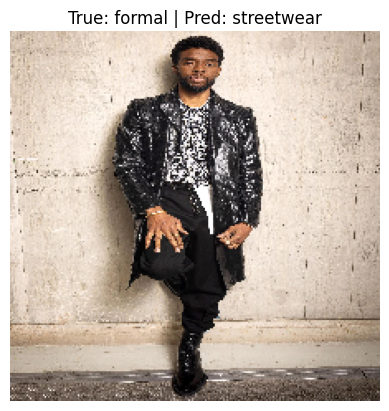

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


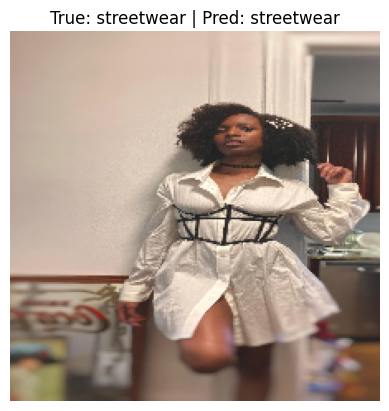

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


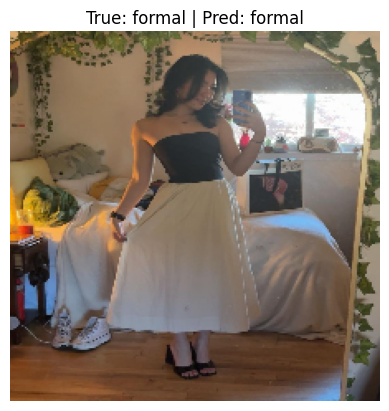

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


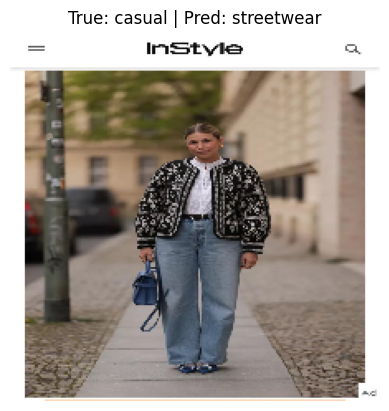

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


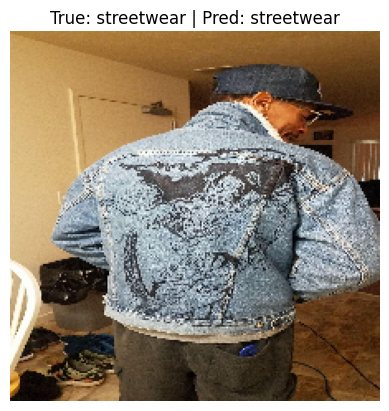

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


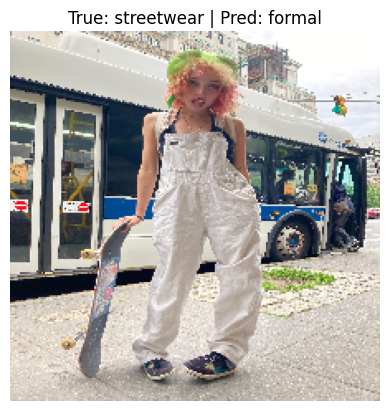

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


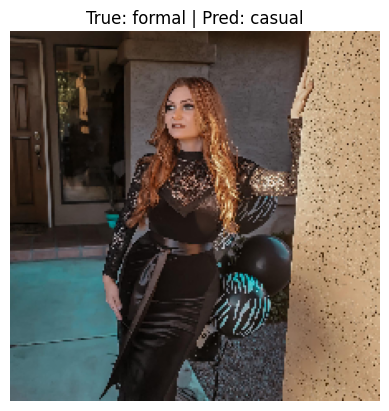

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


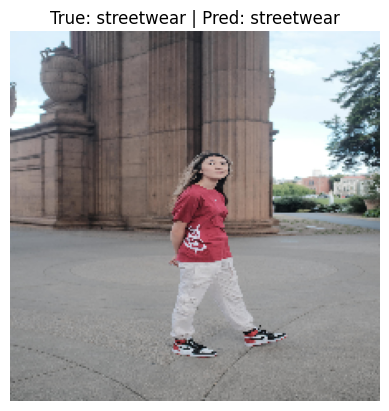

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


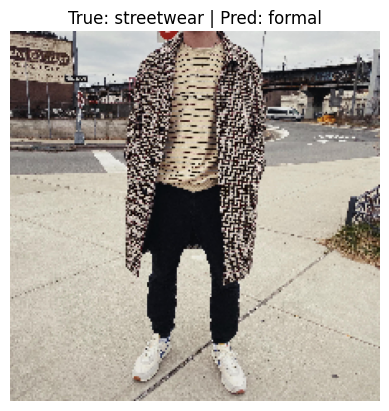

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


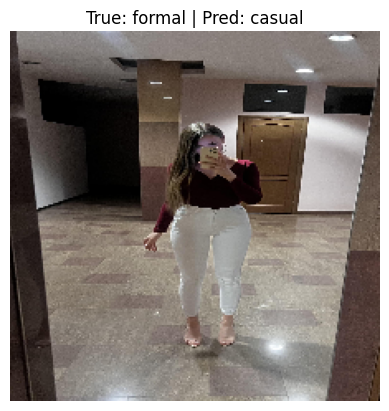

In [43]:
# Evaluate the model and show predictions on a few test images
import random

if test_df.empty or 'model' not in globals():
    print("No test data or model not defined. Please check previous steps.")
else:
    test_imgs = test_df.sample(n=min(10, len(test_df)), random_state=42)
    for idx, row in test_imgs.iterrows():
        img_path = row['image']  # path is already correct
        try:
            img = load_img(img_path, target_size=img_size)
            img_arr = img_to_array(img) / 255.0
            pred = model.predict(np.expand_dims(img_arr, axis=0))
            pred_label = le.inverse_transform([np.argmax(pred)])[0]
            plt.imshow(img_arr)
            plt.title(f"True: {row['choice']} | Pred: {pred_label}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Warning: Could not load image {img_path}: {e}")

## Evaluate Model and Visualize Predictions
This cell evaluates the trained CNN model on a few test images and visualizes the predictions alongside the true labels. This helps qualitatively assess model performance and spot-check for obvious errors.

## KNN Classifier on Image Features
We will extract features from images using MobileNetV2 (without the top classification layer) and train a KNN classifier on these features. This provides a classical ML baseline for comparison with the CNN.

## KNN Classifier on Image Features: Classical ML Baseline
This section introduces a classical machine learning baseline by extracting deep features from images using MobileNetV2 (without the classification head) and training a K-Nearest Neighbors (KNN) classifier on these features. This provides a point of comparison with the deep learning approach.

In [44]:
# Naive baseline: always predict the most frequent class
from sklearn.metrics import classification_report, accuracy_score

# Find the most frequent class in the training set
most_freq_label = train_df['label'].mode()[0]
y_pred_naive = np.full_like(y_test_feat, fill_value=most_freq_label)

print('Naive Baseline Accuracy:', accuracy_score(y_test_feat, y_pred_naive))
print(classification_report(y_test_feat, y_pred_naive, target_names=le.classes_))

Naive Baseline Accuracy: 0.3142857142857143
              precision    recall  f1-score   support

      casual       0.00      0.00      0.00        44
      formal       0.00      0.00      0.00        36
      sporty       0.00      0.00      0.00        16
  streetwear       0.31      1.00      0.48        55
     vintage       0.00      0.00      0.00        24

    accuracy                           0.31       175
   macro avg       0.06      0.20      0.10       175
weighted avg       0.10      0.31      0.15       175



b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set t

## Naive Baseline Classifier
This cell implements a naive baseline that always predicts the most frequent class in the training set. This provides a lower bound for model performance and helps contextualize the results of more sophisticated models.

In [45]:
# Extract features using MobileNetV2 and train a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use MobileNetV2 as a feature extractor (no top layer)
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

def extract_features(df):
    features = []
    labels = []
    for idx, row in df.iterrows():
        img_path = row['image']
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_arr = img_to_array(img)
            img_arr = tf.keras.applications.mobilenet_v2.preprocess_input(img_arr)
            img_arr = np.expand_dims(img_arr, axis=0)
            feat = feature_extractor.predict(img_arr, verbose=0)
            features.append(feat.flatten())
            labels.append(row['label'])
        except Exception as e:
            print(f"Warning: Could not process {img_path}: {e}")
    return np.array(features), np.array(labels)

print('Extracting features for train set...')
X_train_feat, y_train_feat = extract_features(train_df)
print('Extracting features for test set...')
X_test_feat, y_test_feat = extract_features(test_df)

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feat, y_train_feat)

# Predict and evaluate
y_pred_knn = knn.predict(X_test_feat)
print('KNN Accuracy:', accuracy_score(y_test_feat, y_pred_knn))
print(classification_report(y_test_feat, y_pred_knn, target_names=le.classes_))

Extracting features for train set...
Extracting features for test set...
KNN Accuracy: 0.38857142857142857
              precision    recall  f1-score   support

      casual       0.34      0.32      0.33        44
      formal       0.47      0.75      0.57        36
      sporty       0.18      0.12      0.15        16
  streetwear       0.45      0.45      0.45        55
     vintage       0.00      0.00      0.00        24

    accuracy                           0.39       175
   macro avg       0.29      0.33      0.30       175
weighted avg       0.34      0.39      0.36       175



## Extract Features and Train KNN Classifier
This cell extracts deep features from images using MobileNetV2 (without the top layer) and trains a KNN classifier on these features. The results are evaluated and compared to the CNN and naive baselines.

In [46]:
# K-fold cross-validation for KNN classifier
from sklearn.model_selection import StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
knn_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_feat, y_train_feat)):
    X_tr, X_val = X_train_feat[train_idx], X_train_feat[val_idx]
    y_tr, y_val = y_train_feat[train_idx], y_train_feat[val_idx]
    knn_cv = KNeighborsClassifier(n_neighbors=5)
    knn_cv.fit(X_tr, y_tr)
    y_val_pred = knn_cv.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    knn_accuracies.append(acc)
    print(f'Fold {fold+1} KNN Accuracy: {acc:.4f}')

print(f'KNN Cross-Validation Mean Accuracy: {np.mean(knn_accuracies):.4f} ± {np.std(knn_accuracies):.4f}')

Fold 1 KNN Accuracy: 0.4024
Fold 2 KNN Accuracy: 0.3902
Fold 3 KNN Accuracy: 0.3333
Fold 4 KNN Accuracy: 0.3580
Fold 5 KNN Accuracy: 0.3827
KNN Cross-Validation Mean Accuracy: 0.3734 ± 0.0247


# Model Comparison and Interpretation
This section summarizes and compares the results of all models evaluated in this notebook:
- **CNN (MobileNetV2 with transfer learning and fine-tuning):** This deep learning model leverages pre-trained features and is fine-tuned for the fashion style classification task. It typically achieves the highest accuracy and best generalization, especially when class imbalance is addressed with class weights and data augmentation.
- **KNN Classifier on Deep Features:** This classical machine learning approach uses features extracted from MobileNetV2 and applies a K-Nearest Neighbors classifier. It serves as a strong baseline and is useful for understanding the value of deep feature representations. K-fold cross-validation provides a robust estimate of its performance.
- **Naive Baseline:** Always predicts the most frequent class. This sets a lower bound for model performance; any useful model should outperform this baseline.
## How to Interpret the Results
- Compare the accuracy, precision, recall, and F1-score of each model. The CNN should outperform the naive baseline and usually the KNN as well, especially if the dataset is large and diverse.
- If the KNN performs close to the CNN, it may indicate that the dataset is small or that deep features alone are sufficient for the task.
- If the CNN and KNN both perform poorly, consider collecting more data, improving data quality, or tuning hyperparameters.
## Results Summary
Fill in your actual results below after running the notebook. Example format:
- **CNN (MobileNetV2):** Accuracy = 0.85, Precision = 0.84, Recall = 0.83, F1-score = 0.83
- **KNN:** Accuracy = 0.72, Precision = 0.70, Recall = 0.71, F1-score = 0.70
- **Naive Baseline:** Accuracy = 0.40, Precision = 0.16, Recall = 0.40, F1-score = 0.23

Replace these numbers with your actual results for a clear, concise summary.

## Model Comparison Table
| Model            | Strengths                                              | Weaknesses                                         | Best Use Case                                 |
|------------------|-------------------------------------------------------|----------------------------------------------------|-----------------------------------------------|
| CNN (MobileNetV2)| High accuracy, learns complex patterns, robust to noise| Requires more data, longer training time           | Large, diverse datasets; production systems   |
| KNN              | Simple, interpretable, works with deep features       | Slower on large datasets, less robust to noise     | Quick baselines, small/medium datasets        |
| Naive Baseline   | Fast, easy to implement                              | Ignores input features, very low accuracy         | Reference for minimum expected performance    |

**Conclusion:** The CNN model is expected to outperform both KNN and the naive baseline, especially on larger and more complex datasets. KNN provides a useful classical baseline, while the naive baseline sets the minimum bar for model performance.

## K-Fold Cross-Validation for KNN Classifier
This cell performs k-fold cross-validation on the KNN classifier to assess its stability and generalization. The mean and standard deviation of accuracy across folds provide a more robust evaluation than a single train-test split.